In [1]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K

2021-08-26 20:47:43.800999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-26 20:47:43.801034: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Getting image data into keras¶

In [2]:
# this are the folder names of the things you want to classify
classes = ['fork', 'knife', 'spoon']
# plug in the path to your data folder
base_path = '../images/'

In [3]:
# define an image data generator
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=mobilenet_v2.preprocess_input,
    # fill_mode='nearest',
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True, 
    # zoom_range=0.2,
    # shear_range=0.2    
)

In [4]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=390,
        target_size=(224, 224)
)

Found 391 images belonging to 3 classes.


In [5]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((390, 224, 224, 3), (390, 3))

### Transfer Learning with mobilenet

In [35]:
K.clear_session()

In [36]:
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # we only want to have the base, not the final dense layers (!!! thats the key !!!)
    input_shape=(224, 224, 3)
)

# freeze it!
base_model.trainable = False

In [37]:
model = keras.Sequential()
# pretrained base model with lots of convolution steps
model.add(base_model)

# hidden dense layer
model.add(keras.layers.Dense(24, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())

# output layer
model.add(keras.layers.Dense(len(classes), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.35_224 (Functi (None, 1280)              410208    
_________________________________________________________________
dense (Dense)                (None, 24)                30744     
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 75        
Total params: 441,123
Trainable params: 30,867
Non-trainable params: 410,256
_________________________________________________________________


In [38]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

In [39]:
# observe the validation loss and stop when it does not improve after 5 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [40]:
history = model.fit(xtrain, ytrain, 
                    epochs=50, 
                    verbose=2,
                    batch_size=78, 
                    callbacks=[callback],
                    validation_split=0.2)

print('fit complete')

Epoch 1/50
4/4 - 9s - loss: 1.1313 - categorical_accuracy: 0.4904 - val_loss: 1.1973 - val_categorical_accuracy: 0.3462
Epoch 2/50
4/4 - 4s - loss: 0.6726 - categorical_accuracy: 0.7179 - val_loss: 1.1158 - val_categorical_accuracy: 0.4231
Epoch 3/50
4/4 - 5s - loss: 0.5259 - categorical_accuracy: 0.7917 - val_loss: 0.9683 - val_categorical_accuracy: 0.4487
Epoch 4/50
4/4 - 4s - loss: 0.4305 - categorical_accuracy: 0.8397 - val_loss: 0.8429 - val_categorical_accuracy: 0.5513
Epoch 5/50
4/4 - 4s - loss: 0.3694 - categorical_accuracy: 0.8750 - val_loss: 0.7467 - val_categorical_accuracy: 0.6538
Epoch 6/50
4/4 - 4s - loss: 0.3105 - categorical_accuracy: 0.8974 - val_loss: 0.6997 - val_categorical_accuracy: 0.7051
Epoch 7/50
4/4 - 4s - loss: 0.2775 - categorical_accuracy: 0.9231 - val_loss: 0.6767 - val_categorical_accuracy: 0.7179
Epoch 8/50
4/4 - 4s - loss: 0.2493 - categorical_accuracy: 0.9359 - val_loss: 0.6556 - val_categorical_accuracy: 0.7308
Epoch 9/50
4/4 - 4s - loss: 0.2368 - cat

### Evaluation

Dense(30, 'relu'), Dropout(0.2), Batchnormalization()
- val_categorical_accuracy: 0.8205 (max. 0.9103 means 71/78)
- val_loss: 0.4071 (min. 0.3781)

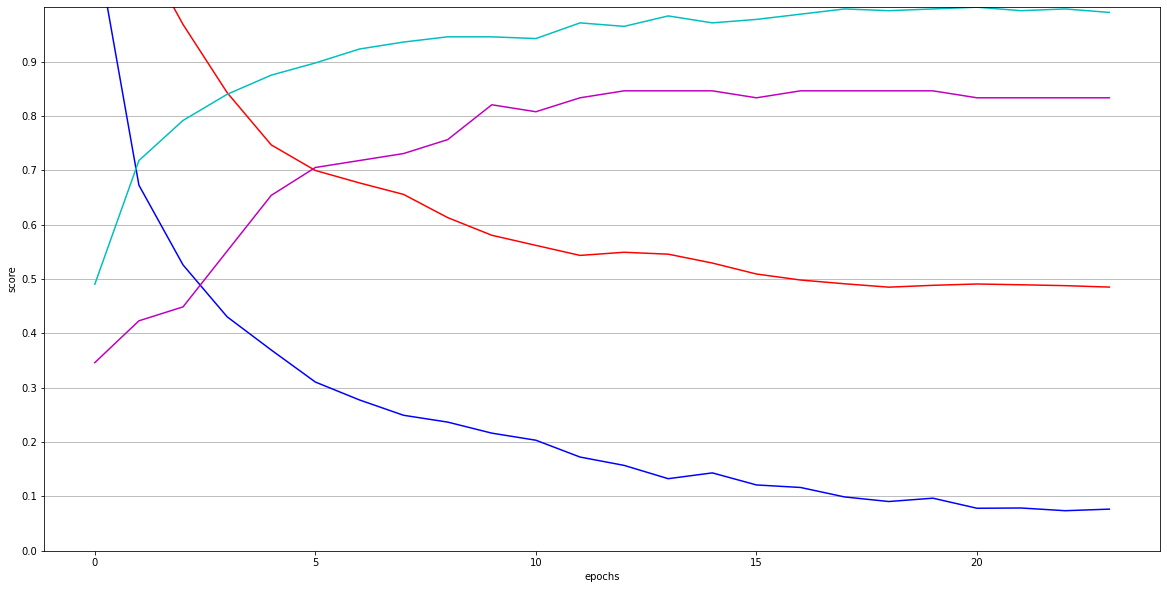

In [41]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], c='b')
plt.plot(history.history['val_loss'], c='r')
plt.plot(history.history['categorical_accuracy'], c='c')
plt.plot(history.history['val_categorical_accuracy'], c='m')
plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.grid(axis = 'y')
plt.xlabel('epochs')
plt.ylabel('score')
plt.show()

In [34]:
model.save('mobilenetV2_cutlery.h5')

/home/nico/anaconda3/envs/my_deep_learning/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
